In [1]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster('spark://master:7077').setAppName('Clustering')
sc = SparkContext(conf=conf)
sc.setLogLevel('ERROR')
sc.version
sc.getConf().getAll()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/18 08:28:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[('spark.app.submitTime', '1671352094843'),
 ('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.master', 'spark://master:7077'),
 ('spark.driver.host', 'master'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '46835'),
 ('spark.app.name', 'Clustering'),
 ('spark.rd

# 1. Load the dataset and perform data preprocessing steps.

In [2]:
# get the header and map with the column index for fast access
header = (
    sc
#     .textFile('data/sample.csv', 8)
    .textFile('data/final_database.csv', 8)
    .take(1)[0]
    .split(',')
)

headerMap = {}
for i in range(len(header)):
    headerMap[header[i]] = i

In [3]:
from csv import reader 
from itertools import islice

fileRDD = (
    sc
#     .textFile('data/sample.csv', 8)
    .textFile('data/final_database.csv', 8)
    .mapPartitionsWithIndex(
        lambda index, it: islice(it, 1, None) if index == 0 else it # remove header line
    )
    # split the line into multiple columns, use csv.reader to avoid comma inside quotes
    .map(lambda x: [item for item in reader([x])][0]) 
)

fileRDD.count()

170633

# 2. Find out the number of unique songs in the dataset.  
Assume the primary key for a song is the title, the artist and the release date

In [4]:
uniqueSongs = (
    fileRDD
    .map(lambda x: (x[headerMap['Title']], x[headerMap['Artist']], x[headerMap['Days_since_release']]))
    .distinct()
)

In [5]:
print(f'Number of unique songs: {uniqueSongs.count()}')

Number of unique songs: 61851


# 3. Plot a bar chart to visualize top 10 popular artists for all countries.  
Assume the popular of the artist is measure by the number of his/her followers

In [6]:
def isFloat(x):
    # check whether string can be casted into a float
    try:
        float(x)
        return True
    except:
        return False

In [7]:
top10Artists = (
    fileRDD
    .filter(lambda x: isFloat(x[headerMap['Artist_followers']]))
    # for two or more artists, the number of followers is prefered to the first person
    .map(lambda x: 
         (x[headerMap['Artist']].split(' - ')[0], float(x[headerMap['Artist_followers']])) 
         if len(x[headerMap['Artist_followers']]) > 0 else (None, None)
        )
    .distinct()
    .filter(lambda x: x[0] != None)
    .takeOrdered(10, lambda x: -x[1])
)

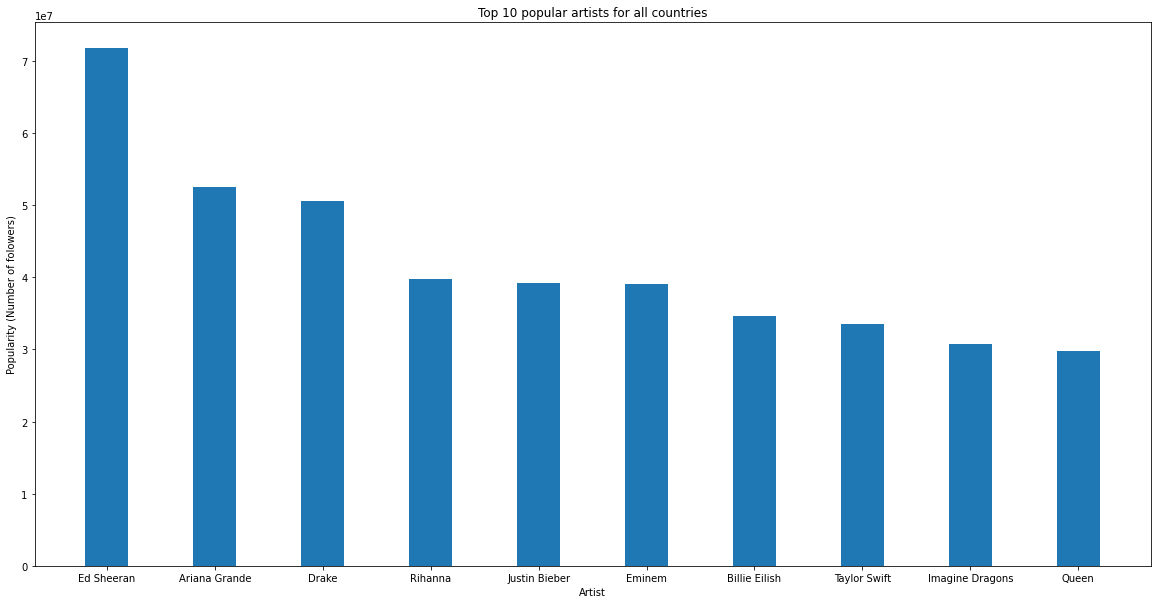

In [8]:
import matplotlib.pyplot as plt

artists = [x[0] for x in top10Artists]
followers = [x[1] for x in top10Artists]

plt.figure(figsize=(20, 10))  # width:20, height:3
plt.bar(artists, followers, width=0.4)
plt.xlabel("Artist")
plt.ylabel("Popularity (Number of folowers)")
plt.title("Top 10 popular artists for all countries")
plt.show()

# 4. Show the most popular song (based on its popularity) for each decade.  

In [9]:
decadePopularSongs = (
    fileRDD
    # filter out the rows with missing value
    .filter(lambda x: all([
                x[headerMap['Release_date']] != '',
                isFloat(x[headerMap['Popularity']]),
                x[headerMap['Title']] != '',
                x[headerMap['Artist']] != ''
            ])

           )
    .map(lambda x: (
        # retrieve the year from the release date
        x[headerMap['Release_date']].split('-')[0],
        (
            float(x[headerMap['Popularity']]), 
            x[headerMap['Title']], 
            x[headerMap['Artist']]
        )
    ))
    # map each year to a decade
    .filter(lambda x: isFloat(x[0]))
    .map(lambda x: (round(int(x[0]) / 10) * 10, x[1]))
    # find the largest popularity in each decade
    .reduceByKey(lambda a, b: a if a[0] > b[0] else b)
    .map(lambda x: [x[0], x[1][0], x[1][1], x[1][2]])
    .sortBy(lambda x: x[0])
    .collect()
)

In [10]:
decadePopularSongs

[[1900, 109.65, 'roll out the barrel', 'The Beverley Sisters'],
 [1930, 22.4, 'when you wish upon a star', 'Cliff Edwards'],
 [1940,
  15917.45,
  'white christmas',
  'Bing Crosby - Ken Darby Singers - John Scott Trotter & His Orchestra'],
 [1950,
  10813.8,
  'let it snow! let it snow! let it snow!',
  'Frank Sinatra - B. Swanson Quartet'],
 [1960, 15868.5, 'its the most wonderful time of the year', 'Andy Williams'],
 [1970, 54580.85000000001, 'rocket man', 'Elton John'],
 [1980, 105904.09999999986, 'dreams - 2004 remaster', 'Fleetwood Mac'],
 [1990, 149127.7500000002, 'ahora te puedes marchar', 'Luis Miguel'],
 [2000, 173246.7999999998, 'dan...', 'Sheila On 7'],
 [2010, 172546.34999999998, 'tadhana', 'Up Dharma Down'],
 [2020, 233766.89999999988, 'shape of you', 'Ed Sheeran']]

In [11]:
from tabulate import tabulate

# draw table 
print(tabulate(
    decadePopularSongs,
    headers=['Decade', 'Popularity', 'Title', 'Artist'], 
    tablefmt="grid"
))

+----------+--------------+-----------------------------------------+----------------------------------------------------------------------+
|   Decade |   Popularity | Title                                   | Artist                                                               |
+==========+==============+=========================================+======================================================================+
|     1900 |       109.65 | roll out the barrel                     | The Beverley Sisters                                                 |
+----------+--------------+-----------------------------------------+----------------------------------------------------------------------+
|     1930 |        22.4  | when you wish upon a star               | Cliff Edwards                                                        |
+----------+--------------+-----------------------------------------+----------------------------------------------------------------------+
|     1940 | 

# 5. Visualize the changing of music over the decades.

In [12]:
labels = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics']

decadeSongCharacteristic = (
    fileRDD
    # filter out all the row with invalid values
    .filter(lambda x:
                x[headerMap['Release_date']] != '' and
                all([isFloat(x[headerMap[label]]) for label in labels])
           )
    #get the decade from the release date
    .map(lambda x: (
        x[headerMap['Release_date']].split('-')[0],
        [
            [float(x[headerMap[label]])] for label in labels
        ]
    ))
    .map(lambda x: (round(int(x[0]) / 10) * 10, x[1]))
    # add all the corresponding attributes
    .reduceByKey(lambda a, b: [a[i] + b[i] for i in range(len(a))])
    # get avaerage value
    .map(lambda x: [x[0]] + [sum(x) / len(x) for x in x[1]])
    .sortBy(lambda x: x[0])
    .collect()
)

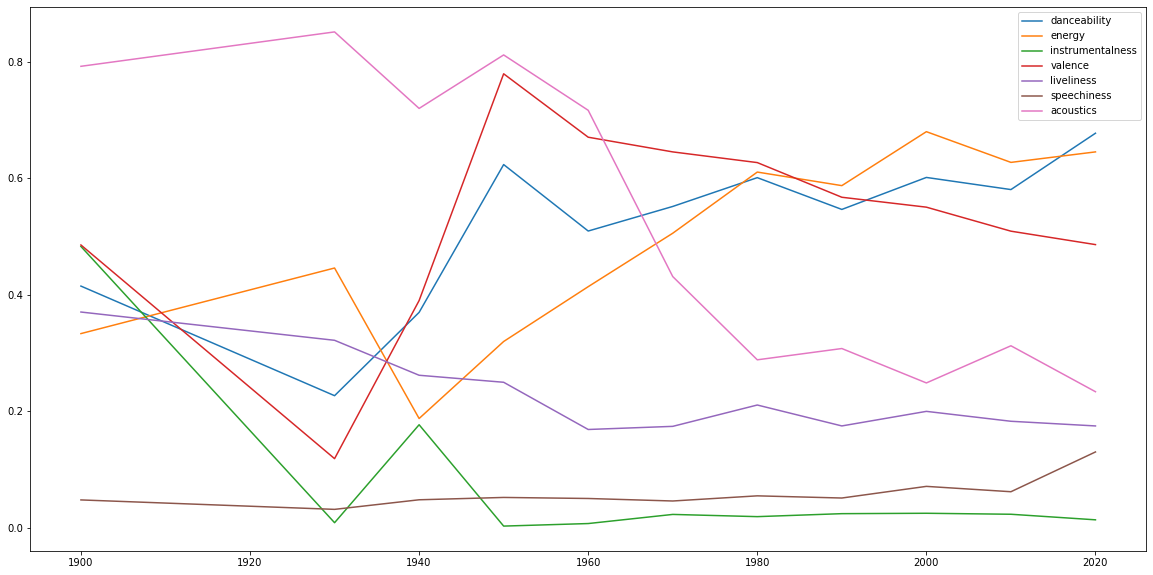

In [13]:
decades = [x[0] for x in decadeSongCharacteristic]
characteristics = [[x[i] for x in decadeSongCharacteristic] for i in range(1, 8)]

plt.figure(figsize=(20, 10))  # width:20, height:3
for i in range(len(labels)):
    plt.plot(decades, characteristics[i], label = labels[i])
plt.legend()
plt.show()

# 6. You are about to build a song recommendation system, so you want to know which songs are related to the others.  
The first step is to clean up the data by filtering out all the non number and unrelated collumns ad then cast the data into number

In [14]:
removeColumns = [
    'Country',
    'Uri', 
    'Album/Single', 
    'Title',
    'Artist',
    'Genre',
    'Explicit',
    'Album',
    'Release_date',
    'Track_number', 
    'Tracks_in_album',
    'duration_ms',
    'key',
    'mode',
    'Genre_new',
    'time_signature',
    'Released_after_2017',
    'Explicit',
    'album',
    'compilation',
    'single',
    'n_words',
    'anger',
    'anticipation',
    'disgust',
    'fear',
    'joy',
    'sadness',
    'surprise',
    'trust',
    'negative',
    'positive',
    'anger_norm',
    'anticipation_norm',
    'disgust_norm',
    'fear_norm',
    'joy_norm',
    'sadness_norm',
    'surprise_norm',
    'trust_norm',
    'negative_norm',
    'positive_norm',
    'LDA_Topic',
    'Cluster'
]
removeIndexes = []
for i in range(len(header)):
    if header[i] in removeColumns:
        removeIndexes.append(i)

In [15]:
cleanRDD = (
    fileRDD
    .map(lambda x: [i for j, i in enumerate(x) if j not in removeIndexes])
    .filter(lambda x: all([isFloat(item) for item in x]))
    .map(lambda x: [float(item) for item in x])
)

Use PCA to get the two principles components from the data  
Use mllib from pyspark to perform the process, which return a list of `DenseVector`

In [16]:
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.ml.linalg import DenseVector

mat = RowMatrix(cleanRDD)

pc = mat.computePrincipalComponents(2)

projected = mat.multiply(pc)

Normalize the data

In [17]:
data = projected.rows
min1 = data.takeOrdered(1, lambda x: x[0])[0][0]
min2 = data.takeOrdered(1, lambda x: x[1])[0][1]
max1 = data.takeOrdered(1, lambda x: -x[0])[0][0]
max2 = data.takeOrdered(1, lambda x: -x[1])[0][1]

data = data.map(lambda x: DenseVector([
    (x[0] - min1) / (max1 - min1),
    (x[1] - min2) / (max2 - min2)
]))

In [18]:
import math 

k = 8 # number of clusters

def cosine(x, y):
    return 1 - x.dot(y)/(x.norm(2)*y.norm(2))

def euclidean(x, y):
    return math.sqrt(x.squared_distance(y))

# Distributed K-means

In [19]:
# Initially choose k points to be the centroids;
centroids = data.take(k)

def assign(x):
    # assign point x to the closest centroid
    distances = [euclidean(x, y) for y in centroids]
    return (x, distances.index(min(distances)))

while(True):
    # step1: Find the closest centroid to each point p in the dataset and assign p to the corresponding cluster
    # generate key-value pair of (p, argmin_i(distance(p, centroids[i])))
    step1 = (
        data
        .map(assign)
    )

    # step2: Update the centroids after adding new points to the clusters
    step2 = (
        step1
        # generate key-value pair (cluster, [p])
        .map(lambda x: (x[1], [x[0]]))
        # reduce to add all the point with same cluster together
        .reduceByKey(lambda x, y: x + y)
        .sortBy(lambda x: x[0])
        # update the centroid for each cluster
        .map(lambda x: sum(x[1]) / len(x[1]))
    )
    new_centroids = step2.collect()
    
    if new_centroids == centroids:
        # if the centroids are converged then stop
        break
    
    centroids = new_centroids

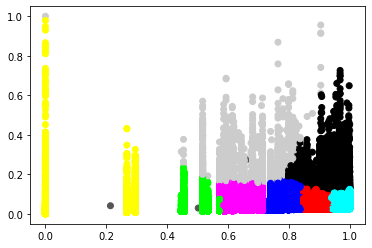

In [20]:
plt.scatter(
    [sample[0] for sample in centroids],
    [sample[1] for sample in centroids],
    color=['#555']*len(centroids)
)

samples = data.collect()

colors = ['#000', '#f00', '#0f0', '#00f', '#ff0', '#f0f', '#0ff', '#ccc']
sample_colors = []
for point in samples:
    distances = [euclidean(point, c) for c in centroids]
    sample_colors.append(colors[distances.index(min(distances))])

plt.scatter(
    [sample[0] for sample in samples],
    [sample[1] for sample in samples],
    color=sample_colors
)
plt.show()


# BFR  


In [21]:
chunk_size = 5000 # the number of points we get from the dataset at each time
offset = 0 # the lower bound value of the points for the next chunk

Mahalanobis_factor=3.0 
Merge_threshold=2.0
Euclidean_threshold=0.05 # This depends on the data. Since we already normalized so 0.05 would be fine

def var(c):
    # Variance of a cluster
    return DenseVector([x for x in c[2]]) / c[0] - (c[1] * c[1]) / (c[0] * c[0])

def std(c):
    # Standard deviation of a cluster
    return DenseVector([(math.sqrt(x) if x > 0 else 0) for x in var(c)])

def centroid(c):
    # Get the centroid of a cluster
    return c[1] / c[0]

def merge(c1, c2, cs):
    # merge the two cluster from the compression set
    # return the new compression set
    merged = (
        c1[0] + c2[0],
        c1[1] + c2[1],
        c1[2] + c2[2]
    )
    std1 = std(c1)
    std2 = std(c2)
    std_merged = std(merged)

    if any([
        (std_merged[i] >= (std1[i] + std2[i]) * Merge_threshold) 
        for i in range(len(std_merged))
    ]):
        # Cannot merge two clusters
        return cs
    
    # Merge two clusters
    cs.remove(c1)
    cs.remove(c2)
    cs.append(merged)
    return cs

def mahalanobis(x, c):
    # Mahalanobis distance from point x to cluster c
    temp = (x - centroid(c)) / std(c)
    return math.sqrt(sum(
        temp * temp
    ))
    
def isNear(x, c):
    # check if point x is 'near' to cluster c
    return mahalanobis(x, c) < Mahalanobis_factor * math.sqrt(len(c[1]))

def addPoint(x, c):
    # add point x to cluster c 
    #return the updated cluster
    return (
        1 + c[0],
        x + c[1],
        x*x + c[2]
    )

In [22]:
# randomly picked point from input points
initial_points = set(data.take(1))

while (len(initial_points) < k):
    #choose the candidate that maximizes the distance to its closest point in initial points
    candidate = (
        data
        .filter(lambda x: x not in initial_points)
        .flatMap(lambda x: [(x, euclidean(x, y)) for y in initial_points])
        .reduceByKey(lambda a, b: min(a, b))
        .takeOrdered(1, lambda x: -x[1])
    )
    
    #append the chosen candidate to initial points
    initial_points.add(candidate[0][0])
    
ds = [(1, x, x*x) for x in initial_points] # Discard set
cs = [] # Compress set
rs = [] # Retain set

for i in range(len(ds)):
    # Find points that are “sufficiently close” to a cluster centroid
    # add those points to that cluster and the Discard set set
    candidates = (
        data
        .filter(lambda x: x not in initial_points)
        .filter(lambda x: euclidean(x, centroid(ds[i])) <= Euclidean_threshold)
        .collect()
    )
    for candidate in candidates:
        initial_points.add(candidate)
        ds[i] = addPoint(candidate, ds[i])
        
    # When clusters are represented by a point, 
    # they have no spread and therefore mahalanobis distance may not be computed.
    # Keep find and add closest point to the cluster until we get a non zero standard deviation
    while 0 in std(ds[i]):
        candidate = (
            data
            .filter(lambda x: x not in initial_points)
            .map(lambda x: (x, euclidean(x, centroid(ds[i]))))
            .takeOrdered(1, lambda x: x[1])
        )[0][0]
        initial_points.add(candidate)
        ds[i] = addPoint(candidate, ds[i])


In [23]:
# filter out all the selected point from the initialization phase
chunks = data.filter(lambda x: x not in initial_points).sortBy(lambda x: x[0])
offset = chunks.take(1)[0][0] - 1

def updateDiscard(point):
    # check whether point can be added to any clsuter in discard set
    closest = -1
    prev = -1
    for i in range(len(ds)):
        dis = mahalanobis(point, ds[i])
        if isNear(point, ds[i]) and (closest == -1 or dis < prev):
            prev = dis
            closest = i
    if closest != -1:
        # Add point to cluster and continue the loop
        ds[closest] = addPoint(point, ds[closest])
        return True
    return False

def updateCompress(point):
    # check whether point can be added to any clsuter in comporess set
    closest = -1
    prev = -1
    for i in range(len(cs)):
        dis = mahalanobis(point, cs[i])
        if isNear(point, cs[i]) and (closest == -1 or dis < prev):
            prev = dis
            closest = i
    if closest != -1:
        cs[closest] = addPoint(point, cs[closest])
        return True
    return False

def updateRetain(point):
    # check whether point can be combine with another point in the retain set
    closest = -1
    prev = -1
    for i in range(len(rs)):
        dis = euclidean(point, rs[i])
        if dis < Euclidean_threshold and (closest == -1 or dis < prev):
            prev = dis
            closest = i
    
    if closest != -1:
        # combine two points into a cluster in compress set and remove the chosen one out of the retain set
        cs.append((
            2,
            point + rs[closest],
            point*point + rs[closest]*rs[closest]
        ))
        rs.remove(rs[closest])
        return True
    return False

while (True):
    chunk = chunks.filter(lambda x: x[0] > offset).take(chunk_size)
    if len(chunk) == 0:
        # there is no other points left
        break
    offset = chunk[-1][0]
    
    #if two clusters in compress are close:34
    #merge them into one
    for point in chunk:
        for i in range(len(cs)):
            for j in range(i+1, len(cs)):
                cs = merge(cs[i], cs[j], cs)
    
    # if point is within threshold to closest cluster in discard:
    # update that cluster with point and continue loop
    if updateDiscard(point):
        continue
        
    #if point is within threshold to closest cluster in compress:
    #update that cluster with point and continue loop
    if updateCompress(point):
        continue
        
    # if point is within threshold to closest point in retain:
    # combine those two points to a cluster and move the resulting cluster to compress
    if updateRetain(point):
        continue
        
    # add point to retain set
    rs.append(point)

        

In [24]:
# merge clusters in compress set to/with their closest cluster in discard. 
for compress in cs:
    distances = [euclidean(centroid(compress), centroid(discard)) for discard in ds]
    index = distances.index(min(distances))
    ds[index] = (
        ds[index][0] + compress[0],
        ds[index][1] + compress[1],
        ds[index][2] + compress[2]
    )
    
for point in rs:
    distances = [euclidean(point, centroid(discard)) for discard in ds]
    index = distances.index(min(distances))
    ds[index] = (
        ds[index][0] + 1,
        ds[index][1] + point,
        ds[index][2] + point * point
    )

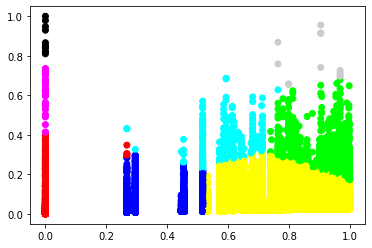

In [25]:
samples = data.collect()

colors = ['#000', '#f00', '#0f0', '#00f', '#ff0', '#f0f', '#0ff', '#ccc']
sample_colors = []
for point in samples:
    distances = [euclidean(point, centroid(discard)) for discard in ds]
    sample_colors.append(colors[distances.index(min(distances))])

plt.scatter(
    [sample[0] for sample in samples],
    [sample[1] for sample in samples],
    color=sample_colors
)

plt.show()